
### YOLOv11 Crochet Stitch Detector - Colab Version
**Author**: Ola Pokorska - github.com/sq7alx

**Description**:
This notebook applies **YOLOv11 computer vision segmenatation model** to **detect crochet stitches** in graphical patterns.
It focuses on the seven most frequent stitch types - covering roughly 90% of crochet stitch symbols to **enable later yarn-usage estimation**.

**Performance:** Model achieves **~0.92 mAP@0.5** on the test set.

**Stitch labels**
- [ch] – chain
- [sc] – single crochet
- [dc] – double crochet
- [hdc] – half double crochet
- [tr] – treble crochet
- [slst] – slip stitch
- [mr] – magic ring


# 1. Environment Setup

In [29]:
!nvidia-smi

Sun Sep 21 19:07:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             33W /   70W |    2154MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [30]:
import os
BASE_DIR = os.getcwd()
print(f"Base project directory: {BASE_DIR}")

Base project directory: /content


# 2. Installing and Checking Dependencies

In [31]:
!pip install ultralytics roboflow

In [32]:
!pip list | grep torch

torch                                 2.8.0+cu126
torchao                               0.10.0
torchaudio                            2.8.0+cu126
torchdata                             0.11.0
torchsummary                          1.5.1
torchtune                             0.6.1
torchvision                           0.23.0+cu126


In [33]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.3/112.6 GB disk)


# 2. Downloading Data from Roboflow

In [34]:
from google.colab import userdata
from roboflow import Roboflow

datasets_dir = os.path.join(BASE_DIR, "datasets")
os.makedirs(datasets_dir, exist_ok=True)
%cd {datasets_dir}

ROBOFLOW_API_KEY = userdata.get("ROBOFLOW_API_KEY")
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("crochetstitchdetector").project("crochet-stitch-detector")
version = project.version(9)
dataset = version.download("yolov11")


/content/datasets
loading Roboflow workspace...
loading Roboflow project...


# 3. Converting Labels from Bounding Boxes to Segmentation

The code below **converts standard YOLO detection labels** (bounding boxes in class_id `[x_center , y_center, width, height]` format) into **segmentation format** (`class + 4 corner points`) required for training segmentation models
.

In [35]:
def convert_box_to_segment(class_id, cx, cy, w, h):
    x1 = cx - w / 2
    y1 = cy - h / 2
    x2 = cx + w / 2
    y2 = y1
    x3 = x2
    y3 = cy + h / 2
    x4 = x1
    y4 = y3
    return f"{class_id} {x1:.6f} {y1:.6f} {x2:.6f} {y2:.6f} {x3:.6f} {y3:.6f} {x4:.6f} {y4:.6f}"

def convert_all_labels(label_dir):
    for fname in os.listdir(label_dir):
        if fname.endswith(".txt"):
            full_path = os.path.join(label_dir, fname)
            with open(full_path, "r") as f:
                lines = f.readlines()

            new_lines = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, cx, cy, w, h = map(float, parts)
                    new_line = convert_box_to_segment(int(class_id), cx, cy, w, h)
                    new_lines.append(new_line)
                else:
                    new_lines.append(line.strip())

            with open(full_path, "w") as f:
                f.write("\n".join(new_lines) + "\n")

# Paths to label directories
train_labels = os.path.join(dataset.location, "train", "labels")
val_labels = os.path.join(dataset.location, "valid", "labels")

convert_all_labels(train_labels)
convert_all_labels(val_labels)

print("Bounding box to segment conversion completed.")

Bounding box to segment conversion completed.


In [36]:
%cd {BASE_DIR}
model_path = os.path.join(BASE_DIR, "yolo11n-seg.pt")

!yolo task=segment mode=train \
    model={model_path} \
    data={os.path.join(dataset.location, "data.yaml")} \
    epochs=200 imgsz=640 plots=False val=True patience=50 exist_ok=True name=train

/content
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/crochet-stitch-detector-9/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pa

In [37]:
from ultralytics import YOLO

model = YOLO("runs/segment/train/weights/best.pt")
metrics = model.val(plots=True)


Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,835,933 parameters, 0 gradients, 9.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1047.8±293.3 MB/s, size: 28.8 KB)
val: Scanning /content/datasets/crochet-stitch-detector-9/valid/labels.cache... 17 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 17/17 38.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.3it/s 1.6s
                   all         17        484      0.905      0.949      0.979      0.772      0.897      0.942       0.97      0.642
                    ch         12        115       0.99          1      0.995      0.725      0.939      0.948      0.928      0.592
                    dc          8         73      0.629      0.928      0.927       0.77      0.629      0.928      0.927      0.581
                   hdc

## Checking Dataset File Counts

In [38]:
from glob import glob
from pathlib import Path

DATA_DIR = Path("datasets") / "crochet-stitch-detector-9" / "train"

imgs = glob(str(DATA_DIR / "images" / "*.jpg"))
labels = glob(str(DATA_DIR / "labels" / "*.txt"))

print(f"Images: {len(imgs)}")
print(f"Labels: {len(labels)}")


Images: 144
Labels: 144


In [39]:
from pathlib import Path
from ultralytics import YOLO

# Configuration
MODEL_PATH = Path("runs") / "segment" / "train" / "weights" / "best.pt"
TEST_IMAGES = Path("datasets") / "crochet-stitch-detector-9" / "test" / "images"

model = YOLO(MODEL_PATH)

results = model.predict(
    source=str(TEST_IMAGES),
    save=True,
    save_txt=True,
    save_conf=True,
    conf=0.25,
    iou=0.5,
    max_det=100,
    imgsz=640,
    verbose=True
)



image 1/15 /content/datasets/crochet-stitch-detector-9/test/images/10_png.rf.af0481311aa6d94c9da0ff1053496202.jpg: 640x640 12 chs, 13 dcs, 4 scs, 9.9ms
image 2/15 /content/datasets/crochet-stitch-detector-9/test/images/11_png.rf.39ec0f6fa4c3dbe84d73b8140e421b86.jpg: 640x640 16 chs, 15 dcs, 1 hdc, 1 mr, 1 tr, 13.4ms
image 3/15 /content/datasets/crochet-stitch-detector-9/test/images/16_png.rf.a7f436797539b4e77052720b0de3493c.jpg: 640x640 6 chs, 9 hdcs, 9.9ms
image 4/15 /content/datasets/crochet-stitch-detector-9/test/images/18_png.rf.bd5ac5dff3b17efd7ca2d48270e297d3.jpg: 640x640 22 chs, 10 dcs, 5 scs, 10.0ms
image 5/15 /content/datasets/crochet-stitch-detector-9/test/images/24_png.rf.fb8fcbfaac2d806903955752b5f719fd.jpg: 640x640 19 chs, 11 dcs, 11.5ms
image 6/15 /content/datasets/crochet-stitch-detector-9/test/images/31_png.rf.5700f84601268f36b1ab388d8c82d92f.jpg: 640x640 21 chs, 3 dcs, 18 scs, 5 slsts, 9.9ms
image 7/15 /content/datasets/crochet-stitch-detector-9/test/images/35_png.rf.2

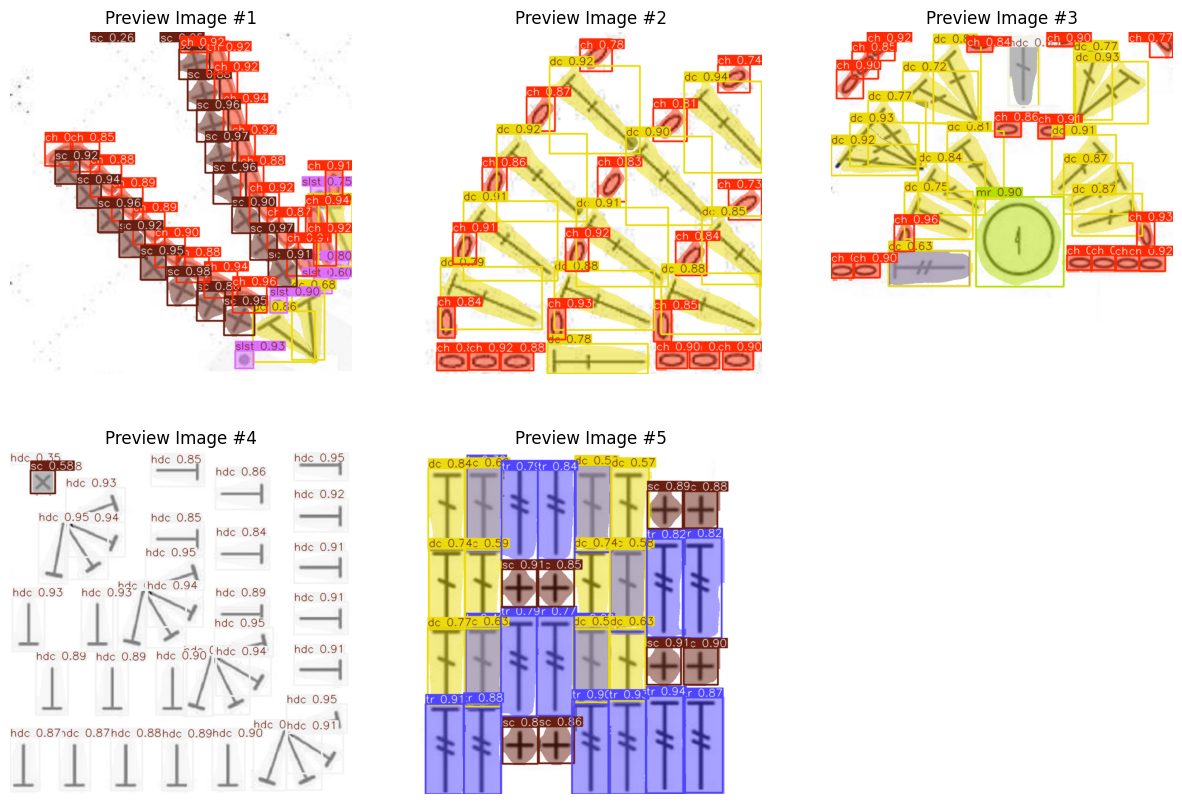

In [45]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Paths (keep in one place)
MODEL_PATH = Path("runs") / "segment" / "train" / "weights" / "best.pt"
TEST_IMAGES = Path("datasets") / "crochet-stitch-detector-9" / "test" / "images"

# Load the model
model = YOLO(MODEL_PATH)

# Select 5 random .jpg files
all_images = list(TEST_IMAGES.glob("*.jpg"))
sample_images = random.sample(all_images, 5)

# Make predictions on the selected images
results = model.predict(
    source=[str(img) for img in sample_images],
    save=False,
    conf=0.25,
    iou=0.5,
    imgsz=640,
    verbose=False
)


fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()  # flatten to 1D array for easier indexing

for i, ax in enumerate(axs):
    if i < len(results):
        img = results[i].plot()
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Preview Image #{i+1}")
    else:
        ax.axis('off')  # empty subplot if no image

plt.show()
